# Postprocessing and Curation with SpikeInterface

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface.full as si
import probeinterface as pi
%matplotlib inline

Download the data for this session (this may take a moment)

In [3]:
import os
import zipfile
import requests

fnames = ["openephys_preprocessed", "results_KS4", "results_SPC", "results_TDC"]
urls = [
    "https://uni-bonn.sciebo.de/s/2LbWWs3VPVrQkLO",
    "https://uni-bonn.sciebo.de/s/26X6qhAAYq1uJfZ",
    "https://uni-bonn.sciebo.de/s/FnRPj7EQSYXFIEg",
    "https://uni-bonn.sciebo.de/s/EkdnDNhvF68HC9D",
]

if not os.path.exists("../data"):
    os.mkdir("../data")

for url, fname in zip(urls, fnames):
    if not os.path.exists(f"../data/{fname}"):
        response = requests.get(f"{url}/download")
        with open(f"{fname}.zip", "wb") as file:
            file.write(response.content)

        with zipfile.ZipFile(f"{fname}.zip", "r") as zip_ref:
            zip_ref.extractall(f"../data/{fname}")
        os.remove(f"{fname}.zip")

## 1 Extracting and Visualizing Spike Waveforms

| Code | Description |
|------------------------------------|------------------------------------|
| `rec = si.load_extractor("mydir")` | Load the recording extractor stored in the folder `"mydir"` |
| `sorting = si.read_sorter_folder("results_SPC")` | Load the spike sorting results stored in the folder `"/results_SPC"` |
| `analyzer = si.create_sorting_analyzer(sorting, recording)` | Create an analyzer by pairing `sorting` results with the respective `recording` and assign the resulting object to a variable `analyzer` |
| `analyzer.compute("extension_name")` | Compute an extension for the `analyzer` with a given name |
| `ext = analyzer.get_extension("extension_name")` | Get an extension from the `analyzer` and assign it to a variable `ext` |

## 2 TODO: Referennce all possible extensions (website?)

<span class="theorem-title">**Example 1**</span> Load the recoring
extractor stored in the directory `"/preprocessed"` and the sorting
results stored in the directory `"/results_TDC"`.

``` python
rec = si.load_extractor("preprocessed")
sort = si.read_sorter_folder("results_TDC")
```

    /tmp/ipykernel_169038/662507394.py:1: DeprecationWarning: load_extractor() is deprecated and will be removed in the future. Please use load() instead.
      rec = si.load_extractor("preprocessed")

<span class="theorem-title">**Exercise 1**</span> Load the spike sorting
results stored in the directory `"/results_SPC"` and assign it to the
variable `sort`.

``` python
sort = si.read_sorter_folder("results_SPC")
```

<span class="theorem-title">**Exercise 2**</span> Create a sorting
analyzer by pairing the sorting results `sort` and the recording `rec`.

``` python
analyzer = si.create_sorting_analyzer(sort, rec)
```

``` json
{"model_id":"4f10e480db3547f9a3ae8d1aab9f7f2c","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

<span class="theorem-title">**Example 2**</span> Randomly sample up to
`300` spikes from every unit.

``` python
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=300)
```

    <spikeinterface.core.analyzer_extension_core.ComputeRandomSpikes at 0x7f5c8a1606e0>

<span class="theorem-title">**Example 3**</span> Get the
`"random_spikes"` extension from the `analyzer` and print the total
number of spikes sampled.

``` python
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))
```

    N_spikes =  34096

<span class="theorem-title">**Exercise 3**</span> Randomly sample up to
`500` spikes per unit and print the total number of spikes sampled.

``` python
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))
```

    N_spikes =  52646

<span class="theorem-title">**Exercise 4**</span> Randomly sample spikes
and use `method="all"` to get **all** of the spikes (omit the
`max_spikes_per_unit` argument). Then, print the total number of spikes
sampled.

``` python
analyzer.compute("random_spikes", method="all")
ext = analyzer.get_extension("random_spikes")
spike_indices = ext.get_data()
print("N_spikes = ", len(spike_indices))
```

    N_spikes =  145296

<span class="theorem-title">**Example 4**</span> Compute the waveforms
for all of the spikes using the signal between `2` milliseconds before
and `3` milliseconds after each spike.

``` python
analyzer.compute("waveforms", ms_before=2, ms_after=3)
```

``` json
{"model_id":"e35ef25320ca44c0a31084413bfcd03b","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

    <spikeinterface.core.analyzer_extension_core.ComputeWaveforms at 0x7f5c482afec0>

<span class="theorem-title">**Example 5**</span> Get the `"waveforms"`
extension from the `analyzer`, then get the array of waveforms for unit
`3` and its `.shape` (dimensions represent spikes, samples and
channels).

``` python
ext = analyzer.get_extension("waveforms")
wfs = ext.get_waveforms_one_unit(unit_id=3)
wfs.shape
```

    (3331, 150, 13)

<span class="theorem-title">**Exercise 5**</span> Compute the waveforms
for all of the spikes using the signal between `1` millisecond before
and `3` milliseconds after each spike. Then, get the waveforms for unit
`3` and print their `.shape`.

``` python
analyzer.compute("waveforms", ms_before=1, ms_after=3)
ext = analyzer.get_extension("waveforms")
wfs = ext.get_waveforms_one_unit(unit_id=3)
wfs.shape
```

``` json
{"model_id":"d4d6e8873f664cfab2b48345172aa1f1","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

    (3331, 120, 13)

<span class="theorem-title">**Exercise 6**</span> Compute the waveforms
for all of the spikes using the signal between `1` millisecond before
and `2` milliseconds after each spike. Then, get the waveforms for three
different units and print their `.shape`.

``` python
analyzer.compute("waveforms", ms_before=1, ms_after=3)
ext = analyzer.get_extension("waveforms")
for unit_id in [5, 34, 103]:
    wfs = ext.get_waveforms_one_unit(unit_id=unit_id)
    print(wfs.shape)
```

``` json
{"model_id":"96ee4452463947ceb9265362dae29acb","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

    (1240, 120, 17)
    (1048, 120, 17)
    (2331, 120, 17)

<span class="theorem-title">**Example 6**</span> Compute the
`"templates"` for the extracted `"waveforms"` using the `"average"`
operator.

``` python
analyzer.compute("templates", operators=["average"])
```

    <spikeinterface.core.analyzer_extension_core.ComputeTemplates at 0x7f5c482ed670>

<span class="theorem-title">**Example 7**</span> Get the template for
unit `3` and print its shape.

``` python
ext = analyzer.get_extension("templates")
template = ext.get_unit_template(unit_id=3, operator="average")
template.shape
```

    (120, 64)

<span class="theorem-title">**Example 8**</span> Get the `"ms_before"`
and `"ms_after"` from `ext.params` and use it to create a vector of time
points for the `template`. Then plot the `template` and label the axes.

``` python
ms_before = ext.params["ms_before"]
ms_after = ext.params["ms_after"]
time_ms = np.linspace(start=-1 * ms_before, stop=ms_after, num=template.shape[0])
plt.plot(time_ms, template)
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [muV]")
```

    Text(0, 0.5, 'Voltage [muV]')

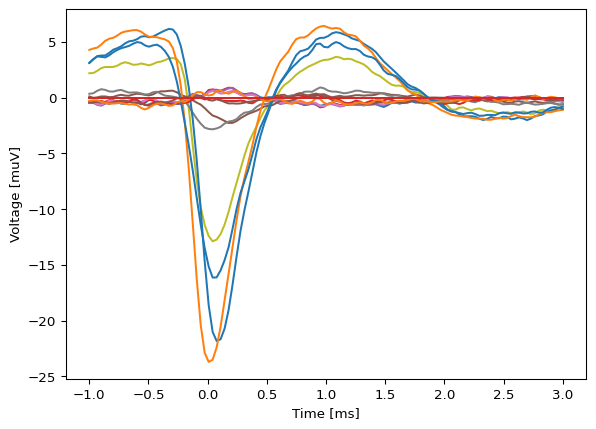

<span class="theorem-title">**Exercise 7**</span> Plot the `template`
for unit `10` as demonstrated in
<a href="#exm-plot_template" class="quarto-xref">Example 8</a>

``` python
template = ext.get_unit_template(unit_id=10, operator="average")
ms_before = ext.params["ms_before"]
ms_after = ext.params["ms_after"]
time_ms = np.linspace(start=-1 * ms_before, stop=ms_after, num=template.shape[0])
plt.plot(time_ms, template)
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [muV]")
```

    Text(0, 0.5, 'Voltage [muV]')

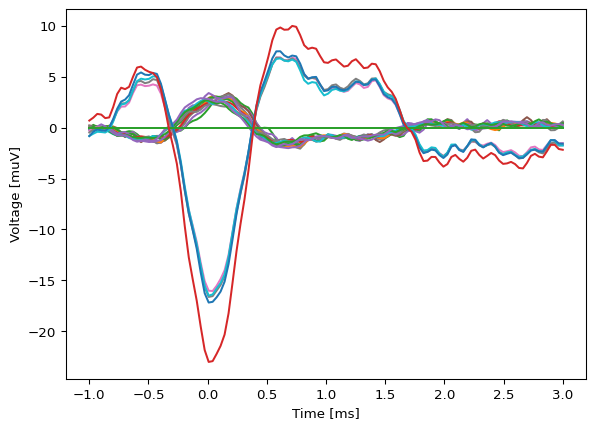

<span class="theorem-title">**Exercise 8**</span> Compute the
`"templates"` for the extracted `"waveforms"` using the `"median"`
operator. Then, get the `template` for unit `10` and plot it.

``` python
analyzer.compute("templates", operators=["median"])
ext = analyzer.get_extension("templates")
template = ext.get_unit_template(unit_id=10, operator="median")
ms_before = ext.params["ms_before"]
ms_after = ext.params["ms_after"]
time_ms = np.linspace(start=-1 * ms_before, stop=ms_after, num=template.shape[0])
plt.plot(time_ms, template)
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [muV]")
```

    Text(0, 0.5, 'Voltage [muV]')

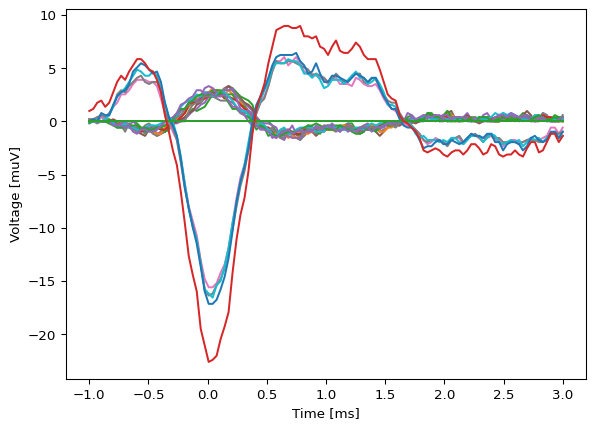

## 3 Localizing Detected Units

| Code | Description |
|------------------------------------|------------------------------------|
| `si.compute_unit_locations(analyzer, method)` | Compute unit locations for a given sorting `analyzer` with the given `method` |
| `ax = plt.subplot(projection='3d')` | Create a 3-dimensional plot and assign the returned axes object to a variable `ax` |
| `ax.scatter(x,y,z)` | Draw a scatter plot to the axes object `ax` |
| `ax.set(xlim=(-1,1), ylim=(-2,2))` | Set the x- and y-limits for `ax` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 9**</span> Run the cell below to
create an interactive widget that shows, for each unit, the waveforms
and the electrode locations where they were recorded. Select five
different neurons and observe the corresponding waveforms. Can you infer
the location of the units from the recorded waveforms?

``` python
%matplotlib widget
si.plot_unit_waveforms(analyzer, backend="ipywidgets")
%matplotlib inline
```

    Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.

``` json
{"model_id":"8baac9c060764851b034fb85af914176","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

<span class="theorem-title">**Example 9**</span> Compute the unit
locations using the `"center_of_mass"` method and print the shape of the
returned `unit_locations`.

``` python
unit_locations = si.compute_unit_locations(analyzer, method="center_of_mass")
unit_locations.shape
```

    (127, 2)

<span class="theorem-title">**Exercise 10**</span> Compute the unit
locations using the `"grid_convolution"` method and print the shape of
the returned `unit_locations`.

``` python
unit_locations = si.compute_unit_locations(analyzer, method="monopolar_triangulation")
unit_locations.shape
```

    (127, 3)

<span class="theorem-title">**Exercise 11**</span> Compute the unit
locations using the `"monopolar_triangulation"` method and print the
shape of the returned `unit_locations`.

``` python
unit_locations = si.compute_unit_locations(analyzer, method="monopolar_triangulation")
unit_locations.shape
```

    (127, 3)

<span class="theorem-title">**Example 10**</span> Create a 3-dimensional
scatter plot for the `unit_locations` computed with the
`"monopolar_triangulation"` method (re-compute the locations if
necessary). Use equal scaling on the x- and y-axis.

``` python
# unit_locations = si.compute_unit_locations(analyzer, method="monopolar_triangulation")
x = unit_locations[:, 0]
y = unit_locations[:, 1]
z = unit_locations[:, 2]
ax = plt.subplot(projection='3d')
ax.scatter(x, y, z) # c=z colors by z-value
ax.set_xlim(-400, 400)
ax.set_ylim(0, 800)
```

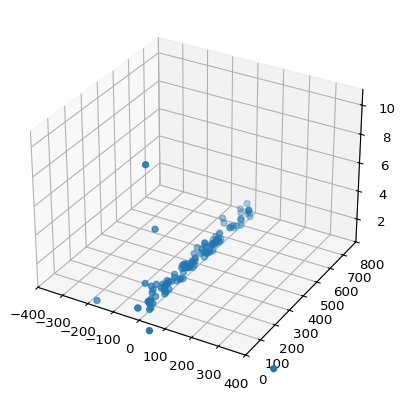

<span class="theorem-title">**Exercise 12**</span> Create a
3-dimensional scatter plot for the `unit_locations` computed with the
`"grid_convolution"` method (re-compute the locations if necessary). Use
equal scaling on the x- and y-axis.

``` python
unit_locations = si.compute_unit_locations(analyzer, method="grid_convolution")
x = unit_locations[:, 0]
y = unit_locations[:, 1]
z = unit_locations[:, 2]
ax = plt.subplot(projection='3d')
ax.scatter(x, y, z) # c=z colors by z-value
ax.set(xlim=(-400, 400), ylim=(0, 800))
```

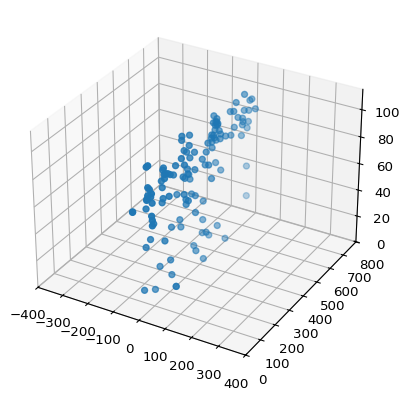

<span class="theorem-title">**Exercise 13**</span> Create a
2-dimensional scatter plot (without using `projection='3d'`) for the
`unit_location` computed with the `"center_of_mass"` method (re-compute
the locations if necessary). Use equal scaling

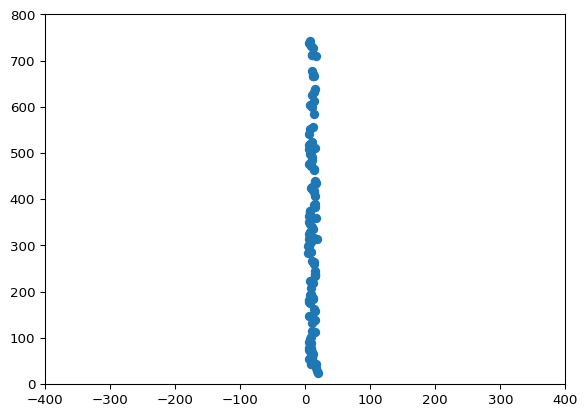

In [26]:
unit_locations = si.compute_unit_locations(analyzer, method="center_of_mass")
x = unit_locations[:, 0]
y = unit_locations[:, 1]
ax = plt.subplot()
ax.scatter(x, y)  # c=z colors by z-value
ax.set(xlim=(-400, 400), ylim=(0, 800))

## 4 Curating Units with Quality Metrics

| Code | Description |
|------------------------------------|------------------------------------|
| `analyzer.compute(extension_name)` | Compute a given extension for the sorting `analyzer` (additional argments depend on the extension) |
| `ext=analyzer.get_extension(extension_name)` | Get the extension with the given name from the sorting `analyzer` |
| `ext.get_data()` | Get data for the extension `ext` |

------------------------------------------------------------------------

<span class="theorem-title">**Example 11**</span> Compute the
`"noise_levels"` and `"quality_metrics"` extension with the metrics
`"snr"` and `"num_spikes"`.

``` python
analyzer.compute("noise_levels")
analyzer.compute("quality_metrics", metric_names=["snr", "num_spikes"])
```

``` json
{"model_id":"26bc79676310475380f9347aa4b824ba","version_major":2,"version_minor":0,"quarto_mimetype":"application/vnd.jupyter.widget-view+json"}
```

    <spikeinterface.qualitymetrics.quality_metric_calculator.ComputeQualityMetrics at 0x7f5c395aa6c0>

<span class="theorem-title">**Example 12**</span> Extract the computed
quality metrics for each unit as a pandas data frame and plot the
`"snr"` as a histogram

``` python
ext = analyzer.get_extension("quality_metrics")
df = ext.get_data()
plt.hist(df["snr"])
plt.xlabel("SNR")
plt.ylabel("Count")
```

    Text(0, 0.5, 'Count')

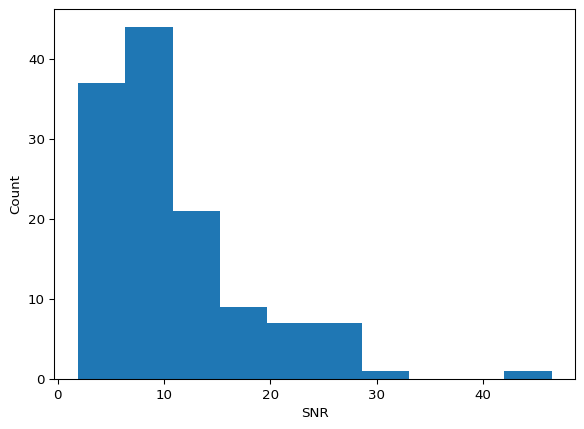

<span class="theorem-title">**Exercise 14**</span> Plot the number of
spikes (`"num_spikes"`) as a histogram.

``` python
plt.hist(df["num_spikes"])
plt.xlabel("Spike Count")
plt.ylabel("Count")
```

    Text(0, 0.5, 'Count')

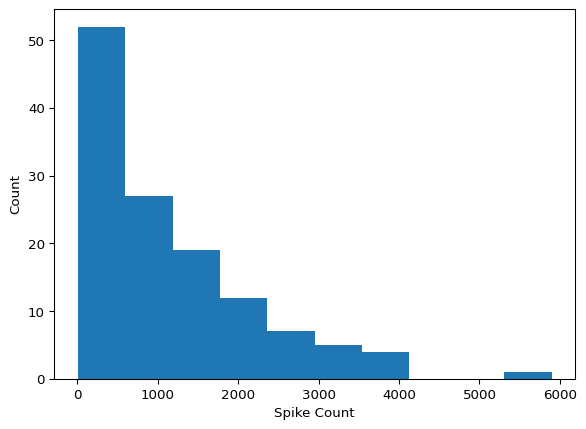

<span class="theorem-title">**Exercise 15**</span> Compute the
`"quality_metrics"` extension with the `"isi_violation"` metric. Then,
extract the data frame and plot a histogram for the
`"isi_violations_count"`.

``` python
analyzer.compute("quality_metrics", metric_names=["isi_violation"])
ext = analyzer.get_extension("quality_metrics")
df = ext.get_data()
plt.hist(df["isi_violations_count"])
plt.xlabel("ISI Violations")
plt.ylabel("Count")
```

    Text(0, 0.5, 'Count')

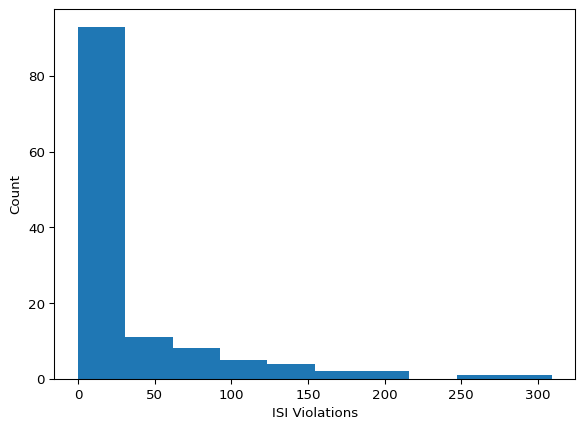

<span class="theorem-title">**Exercise 16**</span> Plot a histogram for
the `"isi_violatios_ratio"` (HINT: you can use the `range` argument of
the `plt.hist()` funtion to restrict the range of the histrogram bins to
exclude outliers.

``` python
plt.hist(df["isi_violations_ratio"], range=(0,10))
plt.xlabel("ISI Violation Ratio")
plt.ylabel("Count")
```

    Text(0, 0.5, 'Count')

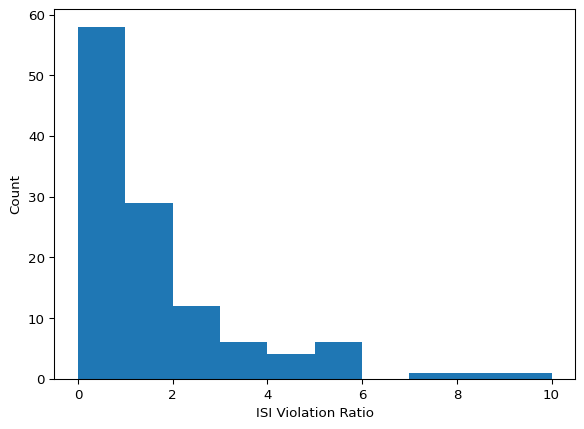

<span class="theorem-title">**Example 13**</span> Get the units with a
SNR above 10.

``` python
unit_ids = analyzer.unit_ids[df["snr"]>10]
unit_ids
```

    array([ 11,  15,  17,  18,  19,  22,  23,  26,  27,  28,  30,  31,  33,
            34,  38,  39,  40,  41,  43,  44,  45,  47,  50,  52,  53,  57,
            59,  60,  61,  63,  65,  68,  72,  75,  76,  78,  79,  81,  82,
            84,  87,  90,  92,  95,  97,  99, 104, 111, 112, 114, 115, 116,
           117])

<span class="theorem-title">**Example 14**</span> Get the units with a
SNR above 10 AND at least 200 recorded spikes.

``` python
unit_ids = analyzer.unit_ids[(df["snr"]>10) & (df["num_spikes"]>=200)]
unit_ids
```

    array([ 15,  17,  18,  19,  22,  23,  26,  27,  28,  31,  33,  34,  38,
            39,  40,  44,  45,  47,  50,  52,  53,  57,  59,  61,  68,  72,
            75,  76,  79,  82,  84,  87,  95,  97,  99, 111, 112, 115, 116,
           117])

<span class="theorem-title">**Exercise 17**</span> Get the units with an
`"isi_violations_ratio"` below 4.

``` python
unit_ids = analyzer.unit_ids[(df["isi_violations_ratio"]<4)]
unit_ids
```

    array([  2,   3,   4,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
            21,  22,  23,  24,  25,  26,  27,  28,  29,  31,  32,  33,  34,
            35,  36,  37,  38,  39,  41,  42,  43,  44,  45,  46,  47,  48,
            49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
            63,  64,  65,  66,  68,  70,  71,  73,  74,  75,  76,  77,  79,
            82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,
            96,  97,  98,  99, 100, 101, 102, 103, 105, 106, 107, 109, 110,
           111, 112, 113, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125,
           126])

<span class="theorem-title">**Exercise 18**</span> Get the units with an
`"isi_violations_ratio"` below 3 AND at least 250 recorded spikes

``` python
unit_ids = analyzer.unit_ids[(df["isi_violations_ratio"]<3) & (df["num_spikes"]>=250)]
unit_ids
```

    array([  2,   3,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
            23,  25,  26,  27,  31,  32,  33,  34,  35,  36,  37,  38,  39,
            42,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
            56,  57,  58,  64,  66,  68,  71,  73,  75,  76,  77,  79,  82,
            83,  84,  85,  87,  88,  89,  93,  94,  95,  96,  97,  98,  99,
           100, 101, 102, 103, 105, 106, 107, 109, 110, 112, 113, 115, 117,
           118, 119, 121, 122, 123, 124, 125, 126])

<span class="theorem-title">**Example 15**</span> Select the curated
unit_ids, save the new sorting object and load it for verification.

``` python
sort_curated = sort.select_units(unit_ids=unit_ids)
sort_curated.save(folder="sorting_curated", overwrite=True)
si.load("sorting_curated")
```

    /home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/render/lib/python3.12/site-packages/spikeinterface/core/basesorting.py:261: UserWarning: The registered recording will not be persistent on disk, but only available in memory
      warnings.warn("The registered recording will not be persistent on disk, but only available in memory")

<div style='border:1px solid #ddd; padding:10px;'><strong>NumpyFolder (NumpyFolderSorting): 86 units - 1 segments - 30.0kHz</strong></div><details style='margin-left: 10px;'>  <summary><strong>Unit IDs</strong></summary><ul>[  2   3  12  13  14  15  16  17  18  19  20  21  22  23  25  26  27  31
  32  33  34  35  36  37  38  39  42  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  64  66  68  71  73  75  76  77  79  82  83  84
  85  87  88  89  93  94  95  96  97  98  99 100 101 102 103 105 106 107
 109 110 112 113 115 117 118 119 121 122 123 124 125 126] </details><details style='margin-left: 10px;'>  <summary><strong>Annotations</strong></summary><ul><li> <strong> __sorting_info__ </strong>: {'recording': {'class': 'spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor', 'module': 'spikeinterface', 'version': '0.102.2', 'kwargs': {'all_annotations': False, 'stream_id': '0', 'folder_path': '/home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/11_spike_sorting_with_spikeinterface/openephys_recording/2023-08-23_15-56-05', 'load_sync_channel': False, 'load_sync_timestamps': False, 'experiment_names': None}, 'annotations': {'is_filtered': False, 'experiment_name': 'experiment1', 'probe_0_planar_contour': [[-10.0, 900.0], [-10.0, -10.0], [12.0, -30.0], [30.0, 10.0], [70.0, 900.0]]}, 'properties': {'group': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'location': [[0.0, 775.0], [0.0, 400.0], [0.0, 450.0], [0.0, 700.0], [0.0, 650.0], [0.0, 575.0], [22.5, 762.5], [22.5, 537.5], [0.0, 750.0], [0.0, 375.0], [0.0, 525.0], [22.5, 437.5], [22.5, 487.5], [22.5, 562.5], [0.0, 550.0], [22.5, 687.5], [0.0, 475.0], [22.5, 787.5], [22.5, 512.5], [0.0, 625.0], [0.0, 725.0], [22.5, 737.5], [0.0, 425.0], [22.5, 662.5], [0.0, 500.0], [0.0, 675.0], [0.0, 600.0], [22.5, 612.5], [22.5, 462.5], [22.5, 587.5], [22.5, 712.5], [22.5, 637.5], [0.0, 275.0], [22.5, 337.5], [22.5, 212.5], [0.0, 100.0], [0.0, 350.0], [22.5, 137.5], [0.0, 50.0], [22.5, 12.5], [22.5, 312.5], [22.5, 162.5], [22.5, 112.5], [22.5, 237.5], [0.0, 175.0], [22.5, 387.5], [0.0, 75.0], [22.5, 262.5], [0.0, 300.0], [0.0, 200.0], [0.0, 325.0], [22.5, 37.5], [0.0, 225.0], [22.5, 412.5], [0.0, 150.0], [22.5, 62.5], [22.5, 287.5], [0.0, 250.0], [22.5, 362.5], [22.5, 87.5], [0.0, 125.0], [0.0, 25.0], [0.0, 0.0], [22.5, 187.5]], 'gain_to_uV': [0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426, 0.1949999928474426], 'offset_to_uV': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'relative_paths': False}, 'params': {'sorter_name': 'spykingcircus2', 'sorter_params': {'general': {'ms_before': 2, 'ms_after': 2, 'radius_um': 75}, 'sparsity': {'method': 'snr', 'amplitude_mode': 'peak_to_peak', 'threshold': 1}, 'filtering': {'freq_min': 150, 'freq_max': 7000, 'ftype': 'bessel', 'filter_order': 2, 'margin_ms': 10}, 'whitening': {'mode': 'local', 'regularize': False}, 'detection': {'peak_sign': 'neg', 'detect_threshold': 5}, 'selection': {'method': 'uniform', 'n_peaks_per_channel': 5000, 'min_n_peaks': 100000, 'select_per_channel': False, 'seed': 42}, 'apply_motion_correction': True, 'motion_correction': {'preset': 'rigid_fast'}, 'merging': {'max_distance_um': 50}, 'clustering': {'legacy': True}, 'matching': {'method': 'circus-omp-svd'}, 'apply_preprocessing': True, 'matched_filtering': True, 'cache_preprocessing': {'mode': 'memory', 'memory_limit': 0.5, 'delete_cache': True}, 'multi_units_only': False, 'job_kwargs': {'n_jobs': 0.5}, 'seed': 42, 'debug': False}}, 'log': {'sorter_name': 'spykingcircus2', 'sorter_version': '2.0', 'datetime': '2025-05-12T12:48:40.874847', 'runtime_trace': [], 'error': False, 'run_time': 207.4290869400029}}</li></details><details style='margin-left: 10px;'><summary><strong>Properties</strong></summary><ul></ul></details>

## 5 Compare Different Sorters

| Code | Description |
|------------------------------------|------------------------------------|
| `comp = si.compare_two_sorters(sorter1, sorter2, "name1", "name2")` | Compare two sorters with given names, returning a sorter comparison object |
| `si.plot_agreement_matrix(comp)` | Plot the agreement matrix for a given sorter comparison |
| `multi_comp = si.compare_multiple_sorters(sorter_list, name_list)` | Compare a list of multiple sorters (with a corresponding list of names), returning a multiple sorter comparison object |
| `si.plot_multicomparison_agreement(multi_comp)` | Plot a pie chart that displays the agreement between the sorters |
| `si.plot_multicomparison_agreement_by_sorter(multi_comp)` | Plot a pie chart that displays the agreement between the sorters separately for each sorter |

<span class="theorem-title">**Example 16**</span> Load the sorting
results from Spikingcircus and Kilosort4 and assign them

``` python
sorting_SPC = si.read_sorter_folder("results_SPC")
sorting_KS4 = si.read_sorter_folder("results_KS4")
```

<span class="theorem-title">**Example 17**</span> Compare the results
from the Spikingcircus and Kilosort4 sorters using the `"count"`
agreement methods and plot the agreement matrix. A clearly visible
diagonal indicates that the sorters agree on a given unit.

``` python
comp = si.compare_two_sorters(
    sorting_SPC, sorting_KS4, "Spikingcircus", "Kilosort4", agreement_method="count"
)
si.plot_agreement_matrix(comp, unit_ticks=False)
```

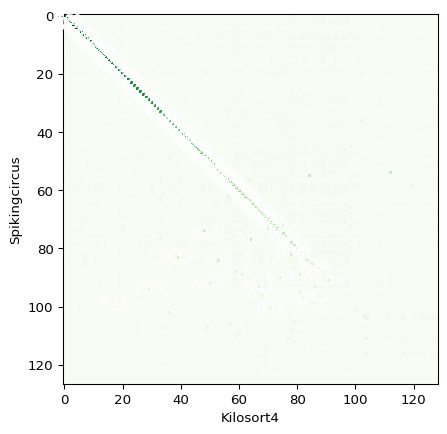

<span class="theorem-title">**Exercise 19**</span> Compare the results
from the Spikingcircus and Kilosort4 sorters using the `"distance"`
agreement methods and plot the agreement matrix.

``` python
comp = si.compare_two_sorters(
    sorting_SPC, sorting_KS4, "SPC", "KS4", agreement_method="distance"
)
si.plot_agreement_matrix(comp, unit_ticks=False)
```

    /home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/render/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
      agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)

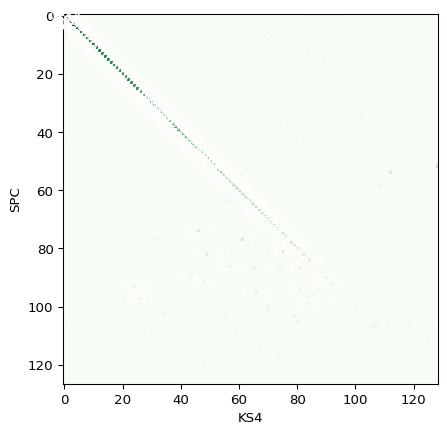

<span class="theorem-title">**Exercise 20**</span> Load the results from
the Tridesclous sorter and compare them to the results from
Spikingcircus by plotting the agreement matrix.

``` python
sorting_TDC = si.read_sorter_folder("results_TDC")
comp = si.compare_two_sorters(
    sorting_SPC, sorting_TDC, "Spikingcircus", "Tridesclous", agreement_method="count"
)
si.plot_agreement_matrix(comp, unit_ticks=False)
```

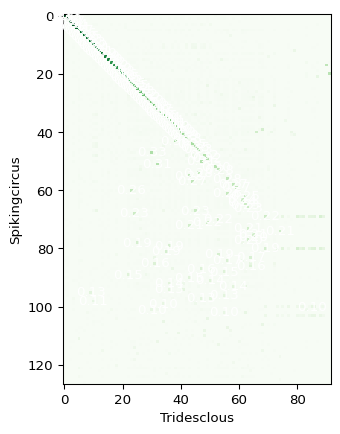

<span class="theorem-title">**Example 18**</span> Compare the results
from all three sorters using the `"count"` agreement method.

``` python
multi_comp = si.compare_multiple_sorters(
    [sorting_SPC, sorting_KS4, sorting_TDC],
    ["Spikingcircus", "Kilosort4", "Tridesclous"],
    agreement_method="count",
)
```

<span class="theorem-title">**Example 19**</span> Plot the
mutlicomparison agreement.

``` python
si.plot_multicomparison_agreement(multi_comp)
```

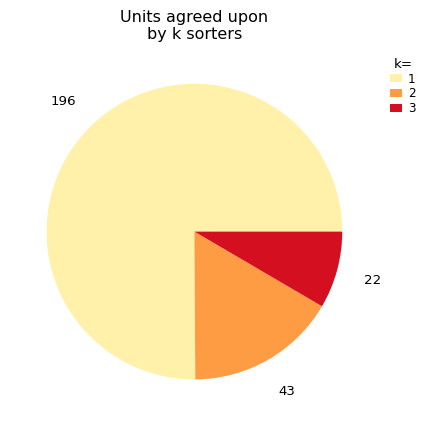

<span class="theorem-title">**Exercise 21**</span> Compare the results
from all three sorters using the `"distance"` agreement method.

``` python
multi_comp = si.compare_multiple_sorters(
    [sorting_SPC, sorting_KS4, sorting_TDC],
    ["Spikingcircus", "Kilosort4", "Tridesclous"],
    agreement_method="distance",
)
```

    /home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/render/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
      agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)
    /home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/render/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
      agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)
    /home/olebi/courses/Intro-to-Neural-Spike-Analysis-in-Python/.pixi/envs/render/lib/python3.12/site-packages/spikeinterface/comparison/comparisontools.py:342: RuntimeWarning: divide by zero encountered in divide
      agreement_matrix = 1 / ((distance_matrix**2 / dot_product_matrix) + 1)

<span class="theorem-title">**Exercise 22**</span> Plot the
mutlicomparison agreement.

``` python
si.plot_multicomparison_agreement(multi_comp)
```

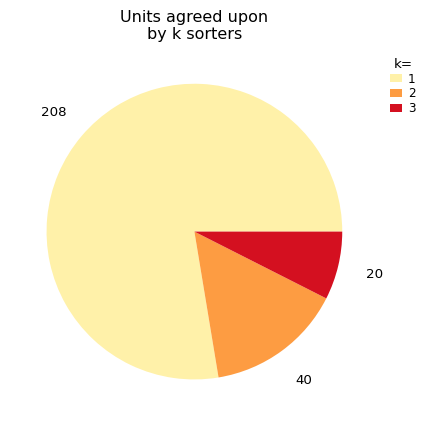

<span class="theorem-title">**Exercise 23**</span> Plot the
mutlicomparison agreement separately for each sorter.

``` python
si.plot_multicomparison_agreement_by_sorter(multi_comp)
```

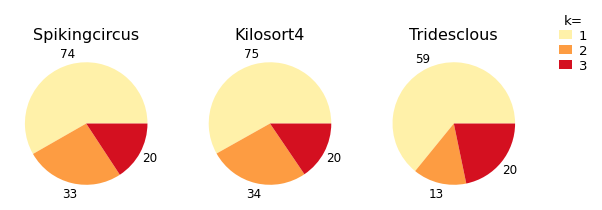